# BERT
BERT stands for Bidirectional Encoder Representations from Transformers is a transformer based language model published by Google Research Team in 2018 in the paper
[BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://doi.org/10.48550/arXiv.2103.11943).

- BERT came in as a response to GPT (Generative Pre-Trained Transformer) that was mastered by OpenAI

- Both BERT and GPT are subsets of the Transformer model, that was published in a paper "*Attention is all you need*".

- While GPT utilizes the decoder part of the transformer, BERT utilizes the encoder part of it.

- BERT can be utilized in task involving Natural Language Understanding(NLU), whereas the GPT can be utilized for tasks invlolving Natural Language Generation(NLG).

- BERT can be utilized for tasks such as semantic analysis. question-answering, text-tagging and sentence classification.

- What sets BERT apart is its ability to capture the context of words in a sentece very well due to its bidirectional training.




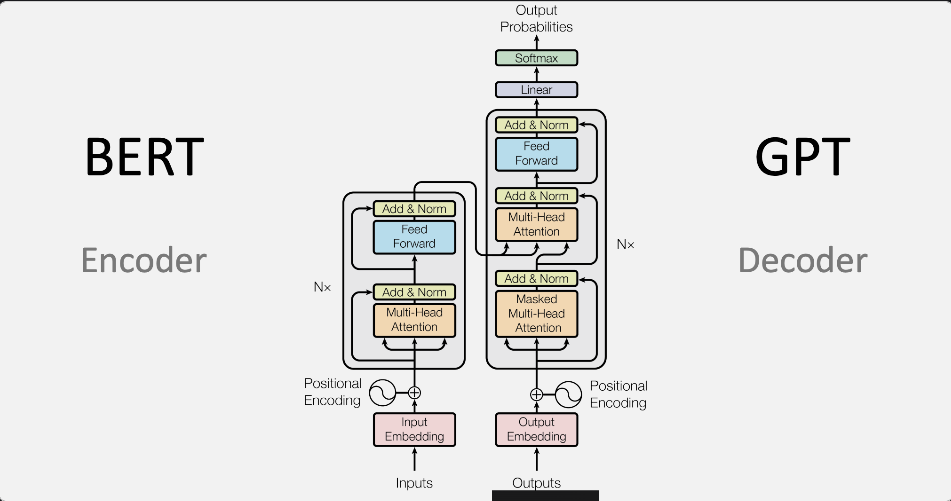

## Dataset
The dataset is a Cornell University dataset *cornell_movie_dialogs_corpus* involving collection of over 220,000 conversational exchanges between more than 10,000 pairs of characters in various movies and TV shows

In [ ]:
!pip install transformers datasets tokenizers
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

## Importing the Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import re
import tqdm
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers, datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
from pathlib import Path



## Preprocesing of the dataset

1. The data corpus is divided into two files, *‘movie_conversations.txt’*
and *‘movie_lines.txt’*.

2. We then split the text in *‘movie_lines.txt’* using a special delimiter (‘+++ $ +++’) to separate the line’s ID, character ID, movie ID, and dialogue text, and store them in a dictionary called line_dic.

3. Next, we generate question-answer pairs by iterating over each conversation in *‘movie_conversations.txt’* and pairing the current line’s text with the next line’s text for each conversation.

4. Finally, we limit the maximum length of the input sequence to 64 tokens, which is a common length used in many NLP tasks, by splitting the text and taking only the first 64 tokens.

In [ ]:
MAX_LEN = 64

## Loading all the data into memory
corpus_movie_conv = '/content/datasets/movie_conversations.txt'
corpus_movie_lines = '/content/datasets/movie_lines.txt'

# ISO 8859-1 is a character encoding standard that defines a set of 256 characters,
#including the 26 alphabet letters (A-Z and a-z), numerals (0-9), punctuation marks, and symbols.

with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
  conv = c.readlines()

with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
  lines = l.readlines()

In [ ]:
## Now we will apply encoding on this to split the text using special lines
lines_dic = {}
for line in lines:
  objects = line.split(' +++$+++ ')
  lines_dic[objects[0]] = objects[-1]

In [ ]:
## Generate question answer pairs
pairs = []
for con in conv:
  ids = eval(con.split(' +++$+++ ')[-1])
  for i in range(len(ids)):
    qa_pairs = []

    if i == len(ids) - 1:
      break

    first = lines_dic[ids[i]].strip()
    second = lines_dic[ids[i+1]].strip()

    qa_pairs.append(' '.join(first.split()[:MAX_LEN]))
    qa_pairs.append(' '.join(second.split()[:MAX_LEN]))
    pairs.append(qa_pairs)

In [ ]:
print(pairs[20])

["I really, really, really wanna go, but I can't. Not unless my sister goes.", "I'm workin' on it. But she doesn't seem to be goin' for him."]


## Word Piece Tokenization
- The initial stage of creating a fresh BERT model involves training a new tokenizer.

- Tokenization is the process of breaking down a text into small units called 'tokens', which are then converted into a numerical representation.

- A Tokenization in BERT starts with a **[CLS]** (classification) token and ends with a **[SEP]** (seperation) token




- BERT employs a WordPiece tokenizer, which can split a single word into multiple tokens
(eg. "surfboarding" into ['surf', '##boarding', '##ing'])

- This technique helps the model to understand words like surfboard and snowboard have shared meaning through wordpiece [##board]

- WordPiece computes a score for each pair, using the following:

**score=(freq_pair)/(freq_first_element * freq_second_element)**

Note: the frequencies of both elements are multiplied as to prioritize the merging of pairs where the individual parts are less frequent in the vocabulary

In [ ]:
# WordPiece Tokenizer
os.mkdir('./data')
text_data = []
file_count = 0

In [ ]:
for sample in tqdm.tqdm([x[0] for x in pairs]):
  text_data.append(sample)

  # once we hit the 10K mark, save to file
  if len(text_data) == 10000:
    with open(f'./data/text_{file_count}.txt','w', encoding='utf-8') as fp:
      fp.write('\n'.join(text_data))
    text_data = []
    file_count += 1

paths = [str(x) for x in Path('./data').glob('**/*.txt')]

100%|██████████| 221616/221616 [00:00<00:00, 1843044.75it/s]


## Tokenization
Tokenization refers to the process of converting words/text into tokens. This helps the model in getting a better understanding of the text.

We have already pre-processed the dataset in such a way that only text is present in the dataset.

While we are creating BERT from scratch, we will also train our tokenizer from scratch using **BertWordPieceTokenizer**.

In [ ]:
# Training your own tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text = True,
    handle_chinese_chars = False,
    strip_accents = False,
    lowercase = True
)

In [ ]:
tokenizer.train(
    files=paths,
    vocab_size=30000,
    min_frequency=2,
    limit_alphabet=1000,
    wordpieces_prefix = '##',
    special_tokens = ['[PAD]', '[UNK]','[CLS]','[MASK]','[SEP]']
)

os.mkdir('./bert-it-1')
tokenizer.save_model('./bert-it-1','bert-it')
tokenizer = BertTokenizer.from_pretrained('./bert-it-1/bert-it-vocab.txt', local_files_only=True)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1962: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


special tokens:

**[CLS]**: Classification token(used in start of sentence)

**[SEP]** : sepration Token(seperates the sentences(if needed) or end of the MAX_LEN no. of tokens)

**[UNK]** : Unknown token(token that is not present in the BERT corpus)

**[PAD]** : padding token(if the sentence tokens doesn't fill up the MAX_LEN of tokens, we apply padding)

**[MASK]** : mask token(for word replacement during masked language prediction)

## Pre-Training Strategy (Pre-Processing)
The unique pre-training strategy of BERT are the one of the many reasons for BERT to account for a sentence’s context. BERT does not try to predict the next word in the sentence but instead makes use of the following two strategies:

1. **<u>Masked Language Model (MLM)</u>**:
The simple idea by masking 15% of the words with MASK token and predict them. Yet, there is a problem with this masking approach as the model only tries to predict when the [MASK] token is present in the input, while we want the model to try to predict the correct tokens regardless of what token is present in the input. To deal with this issue, out of the 15% of the tokens selected for masking:
- 80% of the tokens are actually replaced with the token [MASK].
- 10% of the time tokens are replaced with a random token.
- 10% of the time tokens are left unchanged.

2. **<u>Next Sentence Prediction (NSP)</u>**:
The NSP task forces the model to understand the relationship between two sentences. In this task, BERT is required to predict whether the second sentence is related to the first one. During training, the model is fed with 50% of connected sentences and another half with random sentence sequence.

In [ ]:
class BertDataset(Dataset):
  def __init__(self, data_pair, tokenizer, seq_len=64):
    self.tokenizer = tokenizer
    self.seq_len = seq_len
    self.corpus_lines = len(data_pair)
    self.lines = data_pair

  def __len__(self):
    return self.corpus_lines

  def __getitem__(self, item):
    # Step 1: Get random sentence pair, either positive or negative(saved as is_next_label)
    t1, t2, is_next_label = self.get_sent(item)

    # Step 2: Replace random words in sentence with mask/random words
    t1_random, t1_label = self.random_word(t1)
    t2_random, t2_label = self.random_word(t2)

    # Step 3: Adding CLS and SEP tokens to start and end of sentences
    # Adding PAD token to labels
    t1 = [self.tokenizer.vocab['[CLS]']] + t1_random + [self.tokenizer.vocab['[SEP]']]
    t2 = t2_random + [self.tokenizer.vocab['[SEP]']]
    t1_label = [self.tokenizer.vocab['[PAD]']] + t1_label + [self.tokenizer.vocab['[PAD]']]
    t2_label = t2_label + [self.tokenizer.vocab['[PAD]']]

    # Step 4: Combine sentence 1 and sentence 2 as one input
    # Adding PAD tokens to make the sentence same length as seq_len
    segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
    bert_input = (t1+t2)[:self.seq_len]
    bert_label = (t1_label+t2_label)[:self.seq_len]
    padding = [self.tokenizer.vocab['[PAD]'] for _ in range (self.seq_len - len(bert_input))]
    bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

    output = {'bert_input': bert_input,
              'bert_label': bert_label,
              'segment_label': segment_label,
              'is_next': is_next_label}

    return {key: torch.tensor(value) for key, value in output.items()}

  def random_word(self, sentence):
    tokens = sentence.split()
    output_label = []
    output = []

    # 15% of the tokens would be replaced
    for i, token in enumerate(tokens):
      prob = random.random()

      # remove CLS and SEP token
      token_id = self.tokenizer(token)['input_ids'][1:-1]

      if prob < 0.15:
        prob = 0.15

        # 80% chance change token to mask token
        if prob < 0.8:
          for i in range(len(token_id)):
            output.append(self.tokenizer.vocab['[MASK]'])

        # 10% chance change token to random token
        elif prob < 0.9:
          for i in range(len(token_id)):
            output.append(random.randrange(len(self.tokenizer.vocab)))

        # 10% chance change token to current token
        else:
          output.append(token_id)

        output_label.append(token_id)

      else:
        output.append(token_id)
        for i in range(len(token_id)):
          output_label.append(0)


    output = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output]))
    output_label = list(itertools.chain(*[[x] if not isinstance(x, list) else x for x in output_label]))
    assert len(output) == len(output_label)
    return output, output_label

  def get_sent(self, index):
    ## Return random sentence pair
    t1, t2 = self.get_corpus_line(index)

    # Negative or positive pair, for next sentence prediction
    if random.random() > 0.5:
      return t1, t2, 1
    else:
      return t1, self.get_random_line(), 0

  def get_corpus_line(self, item):
    ## Return sentence pair
      return self.lines[item][0], self.lines[item][1]

  def get_random_line(self):
    ## Return random single sentence
      return self.lines[random.randrange(len(self.lines))][1]

## Embedding

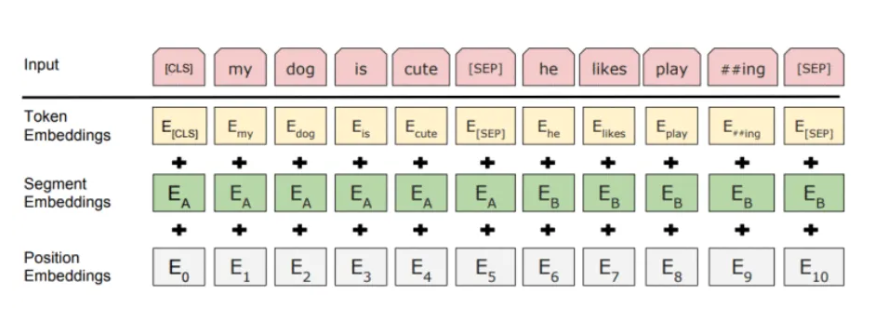

The embeddings in BERT comprises of three parts, mainly the token embeddings, segment embeddings and positional embeddings

token embeddings refers to the embedding given to the token

segment embedding refers to the embedding that classifies that what part of the input sentences' tokens belongs to which segment

for positional embedding, using the idea of position given by the transformer model, we will do positional embedding of each token in the input using the formula

            
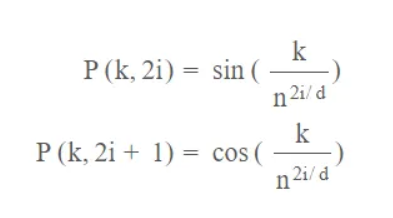



where

**k** : Position of an object in input sequence, 0<k<L/2

**d** : Dimension of the output embedding space

**n**: User defined scaler. Default by 10,000

**i** : Used for mapping to column indices 0 < i < d/2. A single value of i maps to both sine and cosine functions

For all three different type of embeddings, they must be in the similar output size (768 in this case), so that all three of them can be summed together to be a single embedded output. You may notice the **padding_idx** is specified as 0, this is to make pad token remains as 0 and not being updated during training.

In [ ]:
class PositionalEmbedding(torch.nn.Module):
  def __init__(self, d_model, max_len=128):
      super().__init__()
      ## Compute the positional encodings once in log space
      pe = torch.zeros(max_len, d_model).float()
      pe.require_grad = False

      for pos in range(max_len):
      # For each dimension of the each position
        for i in range(0, d_model, 2):
          pe[pos, i] = math.sin(pos /  (10000 ** ((2 * i)/d_model)))
          pe[pos, i+1] = math.cos(pos / (10000 ** ((2 * (i+1))/ d_model)))

        # include the batch size
        self.pe = pe.unsqueeze(0)
        # self.register_buffer('pe',pe)  #register_buffer tells PyTorch: “This tensor (pe) is part of the model, but not a learnable parameter.”

  def forward(self, x):
        return self.pe

In [ ]:
# Combination of all the Embeddings (token, segment and positon), BERT utilizes the summation of these and feeds it to its architecture
class BERTEmbedding(torch.nn.Module):
  ''' BERT Embedding consists of features:
    1. TokenEmbedding: normal embedding matrix
    2. PositionalEmbedding: adding positional information using a sin-cos plot
    3. SegmentEmbedding: adding sentence segment info, (sent_A:1, sent_B:2)
    sum of all of these features are output of BERTEmbedding
  '''
  def __init__(self, vocab_size, embed_size, seq_len=64, dropout=0.1):
    ''' param vocab_size: total vocab size
        param embed_size: embedding size of token embedding
        param dropout: dropout rate
    '''
    super().__init__()
    self.embed_size = embed_size
    #(m ,seq_len) --> (m, seq_len, embed_size)
    #padding_idx is not updated during training, remains as fixed pad (0)
    self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
    self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
    self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
    self.dropout = torch.nn.Dropout(p=dropout)

  def forward(self, sequence, segment_label):
    x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
    return self.dropout(x)

## BERT Architecture

BERT architecture uses the encoder part of the Transformer

In this part, we will create the architecture, this will include things like self-attention, multi-headed attention

Attention modules learns contextual meaning between word and text




## Why do we need attention?

Attention is useful for transformers (and BERT) as they help the encoder look at the other words in the input sentence as it encodes a specific word

Attention works as the focus block, whereas the Feed-forward neural network works as the reasoning block



### Multi-Headed Attention
A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The code snippet for Multi-head attention might looks complicated at first sight, but it is just a simple translation from the equation below

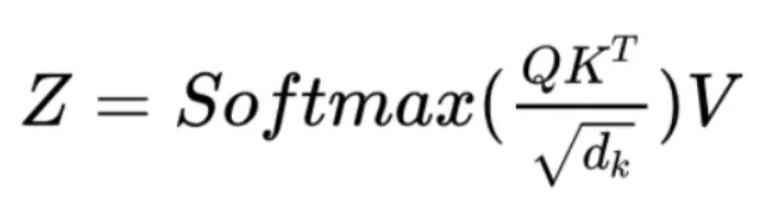


where Q, K, V are identical and linear transformation of input embeddings. The one thing that need more attention is the shape of input tensor, therefore,
.permute() function is applied to amend the shape of tensor to fulfil the requirement for dot product.

- It’s called multi-head attention because the hidden size: d_model(768) is split by heads(12), this allows the model to jointly attend to information at different positions from different representational spaces.

- It takes the query, key, and value as inputs, and the size is permuted from (batch_size, max_len, hidden_size) → (batch_size, num_heads, max_len, hidden_size / num_heads ). This indicates that all the 3 inputs are linearly projected from the d_model dimensional space to heads sets of d_k dimensional vectors.

- Attention score matrix is computed using matrix multiplication between the **query(Q)** and **key(K)** tensors, followed by scaling by the square root of the key tensor’s dimension

- The mask is applied to the attention matrix and filled with -1e9 (close to negative infinity). This is done because the large negative inputs to softmax are near zero in the output.

- The final output is a weighted sum of the **value(V)** tensors, where the weights are determined by the softmax of the scaled dot-product between the query and key vectors.

In [ ]:
### Attention layers
class MultiHeadedAttention(torch.nn.Module):
  def __init__(self, heads, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()

    assert d_model % heads == 0
    self.d_k = d_model // heads
    self.heads = heads
    self.dropout = torch.nn.Dropout(dropout)

    # Q,K,V - Quert, Key and Value Vectors
    self.query = torch.nn.Linear(d_model, d_model)
    self.key = torch.nn.Linear(d_model, d_model)
    self.value = torch.nn.Linear(d_model, d_model)
    self.output_linear = torch.nn.Linear(d_model, d_model)

  def forward(self, query, key, value, mask):
    ''' query, key, value vectors shape = [batch_size, max_len, d_model]
        mask of shape = [batch_size, 1, 1, max_words]
    '''
    query = self.query(query)
    key = self.key(key)
    value = self.value(value)

    # [batch_size, max_len, d_model] --> [batch_size, max_len, h, d_k] --> [batch_size, h, max_len, d_k]
    query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0,2,1,3)
    key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0,2,1,3)
    value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0,2,1,3)

    # [batch_size, h, max_len, d_k] multiply [batch_size, h, d_k, max_len] --> [batch_size, h, max_len, max_len]
    scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))

    # [batch_size, h, max_len, max_len]
    # softmax to put attention weight for all non-pad tokens
    # max_len X max_len matrix of attention
    weights = F.softmax(scores, dim=-1)
    weights = self.dropout(weights)

    # (batch_size, h, max_len, max_len) mutiply (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
    context = torch.matmul(weights, value)

     # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
    context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

    #(batch_size, max_len, d_model)
    return self.output_linear(context)

## Feed-Forward Neural Network

here we will apply the feed-Forward Neural Network
We the feed forward network because it works as the reasoning block after the attention block worked as the focus block

 - **fc1** expands the feature space (e.g., from 768 to 3072 dimensions).

 - **GELU** adds non-linearity, which lets the model learn more complex functions.

- **fc2** reduces it back to 768 so that residual connections can be added safely.

This sequence allows BERT to model complex relationships between tokens beyond what attention alone can do.

In [ ]:
class FeedForward(torch.nn.Module):
  ## Implements Feed Forward Neural Network equation.
  def __init__ (self, d_model, middle_dim=2048, dropout=0.1):
    super(FeedForward, self).__init__()

    self.fc1 = torch.nn.Linear(d_model, middle_dim)
    self.fc2 = torch.nn.Linear(middle_dim, d_model)
    self.dropout = torch.nn.Dropout(dropout)
    self.activation = torch.nn.GELU() # Gaussian Error Linear Unit (combines ReLU and Dropout)

  def forward(self, x):
    out = self.activation(self.fc1(x))
    out = self.fc2(self.dropout(out))
    return out

The EncoderLayer class contains 2 sublayers:.

- <u>**MultiHeadedAttention**</u>: A multi-headed self-attention module that computes the attention weights between each element in the input sequence
- <u>**FeedForward**</u>: A feedforward network with one hidden layer that applies a non-linear activation function (GELU) to the output of the first linear layer and produces a d_model dimensional output.

In [ ]:
class EncoderLayer(torch.nn.Module):
  def __init__(
      self,
      d_model=768,
      heads=12,
      feed_forward_hidden = 768*4,
      dropout=0.1
  ):
    super(EncoderLayer, self).__init__()
    self.layernorm = torch.nn.LayerNorm(d_model)
    self.self_multihead = MultiHeadedAttention(heads, d_model)
    self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, embeddings, mask):
    # embeddings: [batch_size, max_len, d_model]
    # encoder mask: [batch_size, 1, 1, max_len]
    # result: [batch_size, max_len, d_model]
    interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
    # Residual Layer
    interacted = self.layernorm(interacted + embeddings)
    #bottleneck
    feed_forward_out = self.dropout(self.feed_forward(interacted))
    encoded = self.layernorm(feed_forward_out + interacted)
    return encoded

Each of these sublayers has a residual connection around it followed by a layer normalization LayerNorm(x + Sublayer(x)). Residual connections help in avoiding the vanishing gradient problem in deep networks.

## Final BERT model
The **BERT** class initializes the embedding layer for the input sequence, as well as multi layers of EncoderLayer blocks. The forward method of this class takes in the input sequence and a segment info tensor, applies attention masking to the input(for padded token), embeds the input sequence, and then passes it through the encoder blocks to obtain the output.

In [ ]:
class BERT(torch.nn.Module):
  ''' BERT: Bidirectional Encoder Representations from Transformers.'''

  def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
    '''
    :param vocab_size: vocab_size of total words
    :param hidden: BERT model hidden size
    :param n_layers: numbers of Transformer block(layers)
    :param attention_heads: number of attention heads
    :param dropout: dropout rate
    '''

    super().__init__()
    self.d_model = d_model
    self.n_layers = n_layers
    self.heads = heads

    # Paper noted they used 4 * hidden_size for ff_network_hidden_size
    self.feed_forward_forward_hidden = d_model * 4

    # embedding for BERT, sum of positional, segment, token embeddings
    self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)

    # Multi-layers transformer blocks, deep network
    self.encoder_blocks = torch.nn.ModuleList(
        [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

  def forward(self, x, segment_info):
    # Attention masking for padded token
    #[batch_size, 1, seq_len, seq_len]
    mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

    # embedding the indexed sequence to sequence of vectors
    x = self.embedding(x, segment_info)

    # running over multiple transformer blocks
    for encoder in self.encoder_blocks:
      x = encoder.forward(x, mask)
    return x


## Next Sentence Prediction
The **NextSentencePrediction** class is a 2-class classification model that takes in the output of the BERT class and predicts whether the input sequence contains two consecutive sentences or not. The forward method applies applies linear transformation and log softmax function to obtain the predicted probabilities of the two classes.

In [ ]:
class NextSentencePrediction(torch.nn.Module):
  ''' 2-class classification model : is_next, is_not_next'''

  def __init__(self, hidden):
    '''param hidden: BERT model output size'''

    super().__init__()
    self.linear = torch.nn.Linear(hidden, 2)
    self.softmax = torch.nn.LogSoftmax(dim=-1)

  def forward(self, x):
    # use only the first token which is the [CLS]
    return self.softmax(self.linear(x[:, 0]))

In [ ]:
# class MaskedLanguageModel(torch.nn.Module):
#   ''' Predicting origin token from masked input sequence
#       n-class classification problem, n-class = vocab_size'''
#   def __init__ (self, hidden, vocab_size):
#         '''param hidden: output size of BERT model
#            param vocab_size: total vocab size'''
#         super().__init__()
#         self.linear = torch.nn.Linear(hidden, vocab_size)
#         self.softmax = torch.nn.LogSoftmax(dim=-1)

#   def forward(self,x):
#       return self.softmax(self.linear(x))

## Masked Language Model
The **MaskedLanguageModel** class is a multi-class classification model that takes in the output of the BERT class and predicts the original tokens for the masked input sequence. The forward method applies a linear transformation and log softmax function to obtain the predicted probabilities of each token in the vocabulary.

In [ ]:
class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self,x):
       return self.softmax(self.linear(x))

## BertLM
The **BERTLM** class combines the **BERT**, **NextSentencePrediction**, and **MaskedLanguageModel** classes to create a complete BERT language model.

In [ ]:
class BertLM(torch.nn.Module):
  ''' BERT language model
      Next Sentence Prediction(NSP) + Masked Language Model'''
  def __init__ (self, bert:BERT, vocab_size):
        '''
        param bert: BERT model which should be trained
        param vocab_size: total vocab size for masked_lm'''
        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

  def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)


## Optimizer
The original BERT model was trained using Adam optimizer with a custom learning rate scheduler according to the formula in the paper

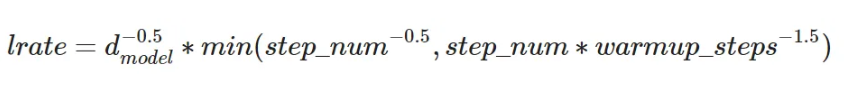

In [ ]:
class SchedulerOptim():
  ''' A simple wrapper class for learning rate scheduling'''

  def __init__(self, optimizer, d_model, n_warmup_steps):
    self._optimizer = optimizer
    self.n_warmup_steps = n_warmup_steps
    self.n_current_steps = 0
    self.init_lr = np.power(d_model, -0.5)

  def step_and_update_lr(self):
    ''' Step with the inner optimizer'''
    self._update_learning_rate()
    self._optimizer.step()

  def zero_grad(self):
    ''' Zero out the gradients by the inner optimizer'''
    self._optimizer.zero_grad()

  def _get_lr_scale(self):
    return np.min([
        np.power(self.n_current_steps, -0.5),
        np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

  def _update_learning_rate(self):
    ''' Learning rate scheduling per step'''

    self.n_current_steps += 1
    lr = self.init_lr * self._get_lr_scale()

    for param_group in self._optimizer.param_groups:
      param_group['lr'] = lr

## Trainer
Here the training of the BERT model starts

The **BERTTrainer** class contains train() and test() methods that call the iteration() method to iterate over the given dataloader (train or test) for a specified epoch. The iteration() method calculates the loss and accuracy of the model on the given data and updates the parameters using backpropagation and optimization. It also logs the progress of training with a progress bar and prints the average loss and accuracy at the end of each epoch. Finally, we can do a test run for the BERT model on the processed data with low number of epochs count.

In [ ]:
class BERTTrainer():
  def __init__(
      self,
      model,
      train_dataloader,
      test_dataloader = None,
      lr = 1e-4,
      weight_decay = 0.01,
      betas = (0.9, 0.999),
      warmup_steps = 10000,
      log_freq=10,
      device='cuda'
  ):
      self.device = device
      self.model = model
      self.train_data = train_dataloader
      self.test_data = test_dataloader

      # Setting the Adam optimizer with hyper-param
      self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
      self.optim_schedule = SchedulerOptim(self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps)

      # Using Negative Log Likelihood loss (NLLL) function for predicting the masked_token
      self.criterion = torch.nn.NLLLoss(ignore_index=0)
      self.log_freq = log_freq
      print("Total parameters: ", sum([p.nelement() for p in self.model.parameters()]))


  def train(self, epoch):
    self.iteration(epoch, self.train_data)

  def test(self, epoch):
    self.iteration(epoch, self.test_data, train=False)

  def iteration(self, epoch, data_loader, train=True):
    avg_loss = 0.0
    total_correct = 0
    total_element = 0

    mode = "Train" if train else "Test"

    # Progress Bar
    data_iter = tqdm.tqdm(enumerate(data_loader), desc="EP_%s:%d" % (mode, epoch), total=len(data_loader), bar_format="{l_bar}{r_bar}")

    for i, data in data_iter:

      # 0. batch_data will be sent into the device
      data = {key : value.to(self.device) for key, value in data.items()}

      # 1. forward the next_sentence_prediction and masked_lm model
      next_sent_output, mask_lm_output = self.model.forward(data['bert_input'], data['segment_label'])

      # 2-1. NLL(Negative Log Likelihood) loss of is_next classification result
      next_loss = self.criterion(next_sent_output, data['is_next'])

      # 2-2. NLLLoss of predicting masked token word
      # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
      # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data['bert_label].view(-1))
      mask_loss = self.criterion(mask_lm_output.transpose(1,2), data['bert_label'])

      # 2-3: Adding next_loss and mask_loss :
      loss = next_loss + mask_loss

      # 3. Backward end optimization only in train
      if train:
        self.optim_schedule.zero_grad()
        loss.backward()
        self.optim_schedule.step_and_update_lr()

      # next sentence prediction accuracy
      correct = next_sent_output.argmax(dim=-1).eq(data['is_next']).sum().item()
      avg_loss +=loss.item()
      total_correct += correct
      total_element += data["is_next"].nelement()

      post_fix = {
          "epoch": epoch,
          'iter': i,
          "avg_loss":avg_loss / (i+1),
          'avg_acc': total_correct / total_element * 100,
          "loss": loss.item()
      }

      if i % self.log_freq == 0:
        data_iter.write(str(post_fix))
    print(
    f'EP{epoch}, {mode}: \
    avg_loss = {avg_loss / len(data_iter)}, \
    total_acc = {total_correct * 100 / total_element}'
    )

## Test Run

In [ ]:
'''test run'''

train_data = BertDataset(
   pairs, seq_len=MAX_LEN, tokenizer=tokenizer)

train_loader = DataLoader(
   train_data, batch_size=32, shuffle=True, pin_memory=True)

bert_model = BERT(
  vocab_size=len(tokenizer.vocab),
  d_model=768,
  n_layers=2,
  heads=12,
  dropout=0.1
)

bert_lm = BertLM(bert_model, len(tokenizer.vocab))
bert_trainer = BERTTrainer(bert_lm, train_loader, device='cpu')
epochs = 20

for epoch in range(epochs):
  bert_trainer.train(epoch)

Total parameters:  60286514


EP_Train:0:   0%|| 1/6926 [00:08<17:18:09,  8.99s/it]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.789895057678223, 'avg_acc': 43.75, 'loss': 11.789895057678223}


EP_Train:0:   0%|| 11/6926 [01:42<17:39:21,  9.19s/it]

{'epoch': 0, 'iter': 10, 'avg_loss': 11.718828808177602, 'avg_acc': 48.01136363636363, 'loss': 11.652790069580078}


EP_Train:0:   0%|| 21/6926 [03:12<17:11:49,  8.97s/it]

{'epoch': 0, 'iter': 20, 'avg_loss': 11.623946099054246, 'avg_acc': 48.36309523809524, 'loss': 11.428960800170898}


EP_Train:0:   0%|| 31/6926 [04:41<17:00:48,  8.88s/it]

{'epoch': 0, 'iter': 30, 'avg_loss': 11.526819229125977, 'avg_acc': 50.30241935483871, 'loss': 11.159926414489746}


EP_Train:0:   1%|| 41/6926 [06:11<16:59:40,  8.89s/it]

{'epoch': 0, 'iter': 40, 'avg_loss': 11.39906259862388, 'avg_acc': 50.22865853658537, 'loss': 10.933009147644043}


EP_Train:0:   1%|| 51/6926 [07:41<17:15:40,  9.04s/it]

{'epoch': 0, 'iter': 50, 'avg_loss': 11.274335562014112, 'avg_acc': 49.44852941176471, 'loss': 10.641205787658691}


EP_Train:0:   1%|| 61/6926 [09:12<17:14:28,  9.04s/it]

{'epoch': 0, 'iter': 60, 'avg_loss': 11.160580244220672, 'avg_acc': 49.334016393442624, 'loss': 10.52164363861084}


EP_Train:0:   1%|| 71/6926 [10:42<17:11:04,  9.02s/it]

{'epoch': 0, 'iter': 70, 'avg_loss': 11.054038464183538, 'avg_acc': 49.03169014084507, 'loss': 10.385289192199707}


EP_Train:0:   1%|| 81/6926 [12:12<17:05:34,  8.99s/it]

{'epoch': 0, 'iter': 80, 'avg_loss': 10.96192792021198, 'avg_acc': 49.035493827160494, 'loss': 10.267167091369629}


EP_Train:0:   1%|| 91/6926 [13:44<17:23:22,  9.16s/it]

{'epoch': 0, 'iter': 90, 'avg_loss': 10.87840743641277, 'avg_acc': 48.52335164835165, 'loss': 10.146390914916992}


EP_Train:0:   1%|| 101/6926 [15:15<17:11:18,  9.07s/it]

{'epoch': 0, 'iter': 100, 'avg_loss': 10.80730671457725, 'avg_acc': 48.20544554455445, 'loss': 10.099723815917969}


EP_Train:0:   2%|| 111/6926 [16:46<17:04:28,  9.02s/it]

{'epoch': 0, 'iter': 110, 'avg_loss': 10.737279049985043, 'avg_acc': 48.310810810810814, 'loss': 10.035466194152832}


EP_Train:0:   2%|| 121/6926 [18:18<17:37:23,  9.32s/it]

{'epoch': 0, 'iter': 120, 'avg_loss': 10.670990455249123, 'avg_acc': 48.47623966942149, 'loss': 10.087471961975098}


EP_Train:0:   2%|| 131/6926 [19:51<17:33:18,  9.30s/it]

{'epoch': 0, 'iter': 130, 'avg_loss': 10.601498480061538, 'avg_acc': 48.44942748091603, 'loss': 9.570186614990234}


EP_Train:0:   2%|| 141/6926 [21:23<17:01:46,  9.04s/it]

{'epoch': 0, 'iter': 140, 'avg_loss': 10.537386156988482, 'avg_acc': 48.648049645390074, 'loss': 9.546428680419922}


EP_Train:0:   2%|| 151/6926 [22:53<16:53:28,  8.98s/it]

{'epoch': 0, 'iter': 150, 'avg_loss': 10.470216694257116, 'avg_acc': 48.65480132450331, 'loss': 9.156468391418457}


EP_Train:0:   2%|| 161/6926 [24:23<16:55:15,  9.00s/it]

{'epoch': 0, 'iter': 160, 'avg_loss': 10.40655069173493, 'avg_acc': 48.69953416149068, 'loss': 9.561347961425781}


EP_Train:0:   2%|| 171/6926 [25:55<17:07:49,  9.13s/it]

{'epoch': 0, 'iter': 170, 'avg_loss': 10.33897668715806, 'avg_acc': 48.64766081871345, 'loss': 9.387227058410645}


EP_Train:0:   3%|| 181/6926 [27:26<17:12:43,  9.19s/it]

{'epoch': 0, 'iter': 180, 'avg_loss': 10.27563148835746, 'avg_acc': 48.58425414364641, 'loss': 9.258694648742676}


EP_Train:0:   3%|| 191/6926 [28:57<17:05:07,  9.13s/it]

{'epoch': 0, 'iter': 190, 'avg_loss': 10.200790595009689, 'avg_acc': 48.7401832460733, 'loss': 8.398171424865723}


EP_Train:0:   3%|| 201/6926 [30:27<16:57:10,  9.08s/it]

{'epoch': 0, 'iter': 200, 'avg_loss': 10.129028301333907, 'avg_acc': 48.66293532338308, 'loss': 8.661227226257324}


EP_Train:0:   3%|| 211/6926 [31:57<16:39:34,  8.93s/it]

{'epoch': 0, 'iter': 210, 'avg_loss': 10.071543047213442, 'avg_acc': 48.7707345971564, 'loss': 8.702624320983887}


EP_Train:0:   3%|| 221/6926 [33:29<16:53:09,  9.07s/it]

{'epoch': 0, 'iter': 220, 'avg_loss': 10.003399771263156, 'avg_acc': 48.61425339366516, 'loss': 8.853014945983887}


EP_Train:0:   3%|| 231/6926 [34:58<16:22:39,  8.81s/it]

{'epoch': 0, 'iter': 230, 'avg_loss': 9.93457722354245, 'avg_acc': 48.89069264069264, 'loss': 8.140183448791504}


EP_Train:0:   3%|| 241/6926 [36:29<17:05:00,  9.20s/it]

{'epoch': 0, 'iter': 240, 'avg_loss': 9.873650166998265, 'avg_acc': 48.93672199170124, 'loss': 8.431354522705078}


EP_Train:0:   4%|| 251/6926 [38:02<17:04:27,  9.21s/it]

{'epoch': 0, 'iter': 250, 'avg_loss': 9.818854571338669, 'avg_acc': 49.066235059760956, 'loss': 9.18418025970459}


EP_Train:0:   4%|| 261/6926 [39:31<16:29:20,  8.91s/it]

{'epoch': 0, 'iter': 260, 'avg_loss': 9.76280090726655, 'avg_acc': 49.042145593869726, 'loss': 8.260047912597656}


EP_Train:0:   4%|| 271/6926 [41:03<17:17:27,  9.35s/it]

{'epoch': 0, 'iter': 270, 'avg_loss': 9.70669453258444, 'avg_acc': 49.05442804428044, 'loss': 8.014068603515625}


EP_Train:0:   4%|| 281/6926 [42:33<16:48:33,  9.11s/it]

{'epoch': 0, 'iter': 280, 'avg_loss': 9.652914291599043, 'avg_acc': 49.06583629893239, 'loss': 8.492968559265137}


EP_Train:0:   4%|| 291/6926 [44:02<16:24:01,  8.90s/it]

{'epoch': 0, 'iter': 290, 'avg_loss': 9.602091745002982, 'avg_acc': 49.140893470790374, 'loss': 8.51674747467041}


EP_Train:0:   4%|| 301/6926 [45:32<16:34:02,  9.00s/it]

{'epoch': 0, 'iter': 300, 'avg_loss': 9.55247519895484, 'avg_acc': 49.08637873754153, 'loss': 8.188093185424805}


EP_Train:0:   4%|| 311/6926 [47:03<16:36:27,  9.04s/it]

{'epoch': 0, 'iter': 310, 'avg_loss': 9.500307477172164, 'avg_acc': 49.17604501607717, 'loss': 7.828325271606445}


EP_Train:0:   5%|| 321/6926 [48:35<16:55:48,  9.23s/it]

{'epoch': 0, 'iter': 320, 'avg_loss': 9.45543607373104, 'avg_acc': 49.2601246105919, 'loss': 8.094815254211426}


EP_Train:0:   5%|| 331/6926 [50:04<16:19:16,  8.91s/it]

{'epoch': 0, 'iter': 330, 'avg_loss': 9.4074109083216, 'avg_acc': 49.235271903323266, 'loss': 7.767186164855957}


EP_Train:0:   5%|| 341/6926 [51:38<16:48:38,  9.19s/it]

{'epoch': 0, 'iter': 340, 'avg_loss': 9.36088088950104, 'avg_acc': 49.31268328445748, 'loss': 8.119463920593262}


EP_Train:0:   5%|| 351/6926 [53:11<17:08:37,  9.39s/it]

{'epoch': 0, 'iter': 350, 'avg_loss': 9.31597330767205, 'avg_acc': 49.34116809116809, 'loss': 7.627566814422607}


EP_Train:0:   5%|| 361/6926 [54:40<16:14:09,  8.90s/it]

{'epoch': 0, 'iter': 360, 'avg_loss': 9.27227142577026, 'avg_acc': 49.36807479224377, 'loss': 8.001204490661621}


EP_Train:0:   5%|| 371/6926 [56:10<16:17:38,  8.95s/it]

{'epoch': 0, 'iter': 370, 'avg_loss': 9.2311982195975, 'avg_acc': 49.35141509433962, 'loss': 7.636683464050293}


EP_Train:0:   6%|| 381/6926 [57:40<16:24:25,  9.02s/it]

{'epoch': 0, 'iter': 380, 'avg_loss': 9.189549371013491, 'avg_acc': 49.38484251968504, 'loss': 7.767802715301514}


EP_Train:0:   6%|| 391/6926 [59:12<16:30:08,  9.09s/it]

{'epoch': 0, 'iter': 390, 'avg_loss': 9.14731426556092, 'avg_acc': 49.512468030690535, 'loss': 7.6914191246032715}


EP_Train:0:   6%|| 401/6926 [1:00:42<16:25:19,  9.06s/it]

{'epoch': 0, 'iter': 400, 'avg_loss': 9.109597087203714, 'avg_acc': 49.58697007481297, 'loss': 7.57432746887207}


EP_Train:0:   6%|| 411/6926 [1:02:13<16:41:28,  9.22s/it]

{'epoch': 0, 'iter': 410, 'avg_loss': 9.073310843929468, 'avg_acc': 49.57420924574209, 'loss': 7.631319999694824}


EP_Train:0:   6%|| 421/6926 [1:03:44<16:16:00,  9.00s/it]

{'epoch': 0, 'iter': 420, 'avg_loss': 9.034595418146274, 'avg_acc': 49.68081947743468, 'loss': 7.669759750366211}


EP_Train:0:   6%|| 431/6926 [1:05:19<17:35:08,  9.75s/it]

{'epoch': 0, 'iter': 430, 'avg_loss': 8.99870466245576, 'avg_acc': 49.6084686774942, 'loss': 7.333411693572998}


EP_Train:0:   6%|| 441/6926 [1:06:50<16:06:31,  8.94s/it]

{'epoch': 0, 'iter': 440, 'avg_loss': 8.959171563319337, 'avg_acc': 49.581916099773245, 'loss': 6.841762542724609}


EP_Train:0:   7%|| 451/6926 [1:08:40<22:23:36, 12.45s/it]

{'epoch': 0, 'iter': 450, 'avg_loss': 8.92472827831023, 'avg_acc': 49.48725055432372, 'loss': 7.412946701049805}


EP_Train:0:   7%|| 461/6926 [1:10:19<19:44:12, 10.99s/it]

{'epoch': 0, 'iter': 460, 'avg_loss': 8.889604581928046, 'avg_acc': 49.545824295010846, 'loss': 6.77337646484375}


EP_Train:0:   7%|| 471/6926 [1:12:17<18:39:57, 10.41s/it]

{'epoch': 0, 'iter': 470, 'avg_loss': 8.855239849940986, 'avg_acc': 49.59527600849257, 'loss': 7.445042133331299}


EP_Train:0:   7%|| 481/6926 [1:14:35<25:09:26, 14.05s/it]

{'epoch': 0, 'iter': 480, 'avg_loss': 8.822722390387014, 'avg_acc': 49.53872141372141, 'loss': 7.16714334487915}


EP_Train:0:   7%|| 491/6926 [1:16:39<22:43:23, 12.71s/it]

{'epoch': 0, 'iter': 490, 'avg_loss': 8.787765073679129, 'avg_acc': 49.497199592668025, 'loss': 6.71563196182251}


EP_Train:0:   7%|| 501/6926 [1:18:43<23:00:47, 12.89s/it]

{'epoch': 0, 'iter': 500, 'avg_loss': 8.754064531383401, 'avg_acc': 49.42614770459082, 'loss': 7.2840118408203125}


EP_Train:0:   7%|| 511/6926 [1:20:49<23:20:53, 13.10s/it]

{'epoch': 0, 'iter': 510, 'avg_loss': 8.721308020462962, 'avg_acc': 49.4190313111546, 'loss': 7.046574592590332}


EP_Train:0:   8%|| 521/6926 [1:22:58<21:56:48, 12.34s/it]

{'epoch': 0, 'iter': 520, 'avg_loss': 8.69107513281297, 'avg_acc': 49.532149712092135, 'loss': 7.329514503479004}


EP_Train:0:   8%|| 531/6926 [1:24:32<16:42:21,  9.40s/it]

{'epoch': 0, 'iter': 530, 'avg_loss': 8.660648829070412, 'avg_acc': 49.59392655367232, 'loss': 7.259625434875488}


EP_Train:0:   8%|| 541/6926 [1:26:38<21:41:26, 12.23s/it]

{'epoch': 0, 'iter': 540, 'avg_loss': 8.630243861961718, 'avg_acc': 49.52056377079482, 'loss': 6.896356582641602}


EP_Train:0:   8%|| 551/6926 [1:28:38<25:19:19, 14.30s/it]

{'epoch': 0, 'iter': 550, 'avg_loss': 8.59792955384713, 'avg_acc': 49.563294010889294, 'loss': 6.548996448516846}


EP_Train:0:   8%|| 561/6926 [1:30:20<16:23:40,  9.27s/it]

{'epoch': 0, 'iter': 560, 'avg_loss': 8.567254723499591, 'avg_acc': 49.621212121212125, 'loss': 6.8524298667907715}


EP_Train:0:   8%|| 571/6926 [1:31:51<15:50:28,  8.97s/it]

{'epoch': 0, 'iter': 570, 'avg_loss': 8.537665711184099, 'avg_acc': 49.55669877408056, 'loss': 7.024697303771973}


EP_Train:0:   8%|| 581/6926 [1:33:21<16:14:03,  9.21s/it]

{'epoch': 0, 'iter': 580, 'avg_loss': 8.50694193158831, 'avg_acc': 49.55357142857143, 'loss': 6.443992614746094}


EP_Train:0:   9%|| 591/6926 [1:35:19<19:48:17, 11.25s/it]

{'epoch': 0, 'iter': 590, 'avg_loss': 8.479602342531363, 'avg_acc': 49.619289340101524, 'loss': 6.822509765625}


EP_Train:0:   9%|| 601/6926 [1:37:29<22:25:20, 12.76s/it]

{'epoch': 0, 'iter': 600, 'avg_loss': 8.45266314393867, 'avg_acc': 49.60482529118136, 'loss': 6.783106327056885}


EP_Train:0:   9%|| 611/6926 [1:39:29<23:39:26, 13.49s/it]

{'epoch': 0, 'iter': 610, 'avg_loss': 8.423664110186838, 'avg_acc': 49.631751227495904, 'loss': 6.950753688812256}


EP_Train:0:   9%|| 621/6926 [1:41:24<20:23:16, 11.64s/it]

{'epoch': 0, 'iter': 620, 'avg_loss': 8.393518311198015, 'avg_acc': 49.56219806763285, 'loss': 6.168307781219482}


EP_Train:0:   9%|| 631/6926 [1:43:43<23:57:40, 13.70s/it]

{'epoch': 0, 'iter': 630, 'avg_loss': 8.364618723063764, 'avg_acc': 49.61866085578447, 'loss': 6.667653560638428}


EP_Train:0:   9%|| 641/6926 [1:45:43<22:17:21, 12.77s/it]

{'epoch': 0, 'iter': 640, 'avg_loss': 8.338946843110083, 'avg_acc': 49.61973478939157, 'loss': 6.569518566131592}


EP_Train:0:   9%|| 651/6926 [1:47:27<19:57:39, 11.45s/it]

{'epoch': 0, 'iter': 650, 'avg_loss': 8.312543023749614, 'avg_acc': 49.57277265745007, 'loss': 5.960948467254639}


EP_Train:0:   9%|| 656/6926 [1:48:25<17:16:18,  9.92s/it]


KeyboardInterrupt: 

## Conclusion

This concludes are creation of the BERT from scratch. The notebook aims to help understand the working of a Large Language Model used for Natural Language Understanding (NLG) tasks, going through every single step of how the model works.

While creating the BERT model from scratch looks cool, it isn't feasible. On training it for 6926 params, it will take roughly 1 day to run fully on Colab GPU's.

So, it is better to utilize the pre-trained BERT model available on Hugging Face and fine-tune the linear layer according to the project in hand